In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error

2025-06-02 08:08:00.596734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748851680.865554      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748851680.942951      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Đọc dữ liệu
df = pd.read_csv('.\data\processed_gold_data.csv')

In [6]:
# Chọn các features để dự đoán
features = ['gold_last', 'gold_open', 'gold_high', 'gold_low', 'gold_volume', 'gold_change_percent']
target = 'gold_open'

In [7]:
# Kiểm tra và xử lý dữ liệu
print("Columns in dataset:", df.columns.tolist())
print("Dataset shape:", df.shape)

Columns in dataset: ['date', 'gold_last', 'gold_open', 'gold_high', 'gold_low', 'gold_volume', 'gold_change_percent', 'oil_last', 'oil_open', 'oil_high', 'oil_low', 'oil_volume', 'oil_change_percent', 'dxy_last', 'dxy_open', 'dxy_high', 'dxy_low', 'dxy_change_percent', 'sp500_last', 'sp500_open', 'sp500_high', 'sp500_low', 'sp500_change_percent']
Dataset shape: (11831, 23)


In [8]:
df

,date,gold_last,gold_open,gold_high,gold_low,gold_volume,gold_change_percent,oil_last,oil_open,oil_high,...,dxy_last,dxy_open,dxy_high,dxy_low,dxy_change_percent,sp500_last,sp500_open,sp500_high,sp500_low,sp500_change_percent
0,1993-01-01,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473,-1.190848,-1.187313,-1.197895,...,-0.032182,-0.049746,-0.056348,-0.040998,-0.012325,-1.095979,-1.093477,-1.095537,-1.093006,-0.659033
1,1993-01-02,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473,-1.190848,-1.187313,-1.197895,...,-0.032182,-0.049746,-0.056348,-0.040998,-0.012325,-1.095979,-1.093477,-1.095537,-1.093006,-0.659033
2,1993-01-03,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473,-1.190848,-1.187313,-1.197895,...,-0.032182,-0.049746,-0.056348,-0.040998,-0.012325,-1.095979,-1.093477,-1.095537,-1.093006,-0.659033
3,1993-01-04,-1.013075,-1.011814,-1.014711,-1.012439,-0.794728,-1.409866,-1.206730,-1.192839,-1.203351,...,0.072461,-0.028816,0.057388,0.001029,2.433403,-1.096209,-1.095929,-1.097290,-1.093931,-0.096109
4,1993-01-05,-1.012156,-1.011968,-1.014559,-1.009351,-0.735929,0.133485,-1.199134,-1.205618,-1.210513,...,-0.006497,0.063470,0.056441,-0.010433,-1.841483,-1.097052,-1.096235,-1.098738,-1.094624,-0.254432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11826,2025-05-19,3.437670,3.416814,3.429109,3.439422,1.015917,-0.186833,0.281368,0.276717,0.270310,...,0.735515,0.780820,0.746440,0.734591,-1.368779,3.137912,3.092568,3.118497,3.112911,0.044622
11827,2025-05-20,3.515957,3.436729,3.498423,3.436796,1.430062,1.492411,0.277570,0.282588,0.267922,...,0.706025,0.736104,0.716110,0.729815,-0.649447,3.120189,3.124576,3.106646,3.123364,-0.377571
11828,2025-05-21,3.572704,3.528644,3.542048,3.559730,-0.892336,1.055614,0.243043,0.265665,0.296570,...,0.652752,0.694243,0.660190,0.665820,-1.163256,3.046776,3.098161,3.095449,3.063010,-1.450645
11829,2025-05-22,3.539627,3.572488,3.571461,3.545846,1.216663,-0.672164,0.229578,0.235963,0.218471,...,0.690804,0.660944,0.672512,0.675371,0.809768,3.044785,3.045360,3.049498,3.059089,-0.069722


In [9]:
# Lấy dữ liệu features và target
df_features = df[features].copy()
df_target = df[target].copy()

In [10]:
# Xử lý giá trị missing nếu có
df_features = df_features.fillna(method='ffill').fillna(method='bfill')
df_target = df_target.fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_35/2924334765.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_35/2924334765.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_target = df_target.fillna(method='ffill').fillna(method='bfill')


In [11]:
print("Features shape:", df_features.shape)
print("Target shape:", df_target.shape)

Features shape: (11831, 6)
Target shape: (11831,)


In [12]:
df_features

,gold_last,gold_open,gold_high,gold_low,gold_volume,gold_change_percent
0,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473
1,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473
2,-1.005875,-1.005380,-1.008479,-1.002401,-0.738055,-0.099473
3,-1.013075,-1.011814,-1.014711,-1.012439,-0.794728,-1.409866
4,-1.012156,-1.011968,-1.014559,-1.009351,-0.735929,0.133485
...,...,...,...,...,...,...
11826,3.437670,3.416814,3.429109,3.439422,1.015917,-0.186833
11827,3.515957,3.436729,3.498423,3.436796,1.430062,1.492411
11828,3.572704,3.528644,3.542048,3.559730,-0.892336,1.055614
11829,3.539627,3.572488,3.571461,3.545846,1.216663,-0.672164


In [13]:
df_target

0       -1.005380
1       -1.005380
2       -1.005380
3       -1.011814
4       -1.011968
           ...   
11826    3.416814
11827    3.436729
11828    3.528644
11829    3.572488
11830    3.572488
Name: gold_open, Length: 11831, dtype: float64

In [14]:
# Chuẩn hóa dữ liệu features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(df_features)

In [15]:
# Chuẩn hóa dữ liệu target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(df_target.values.reshape(-1, 1))

In [16]:
scaled_features

array([[0.0249732 , 0.02485755, 0.02426737, 0.02552865, 0.02471434,
        0.49973075],
       [0.0249732 , 0.02485755, 0.02426737, 0.02552865, 0.02471434,
        0.49973075],
       [0.0249732 , 0.02485755, 0.02426737, 0.02552865, 0.02471434,
        0.49973075],
       ...,
       [0.96731412, 0.95144324, 0.94387786, 0.97053649, 0.00694402,
        0.5638126 ],
       [0.9605064 , 0.96040323, 0.94982183, 0.96766051, 0.24986222,
        0.46795907],
       [0.9605064 , 0.96040323, 0.94982183, 0.96766051, 0.24986222,
        0.46795907]])

In [17]:
scaled_target

array([[0.02485755],
       [0.02485755],
       [0.02485755],
       ...,
       [0.95144324],
       [0.96040323],
       [0.96040323]])

In [18]:
print("Scaled features shape:", scaled_features.shape)
print("Scaled target shape:", scaled_target.shape)

Scaled features shape: (11831, 6)
Scaled target shape: (11831, 1)


In [20]:
# Chia dữ liệu train/test
training_size = int(len(scaled_features) * 0.65)
test_size = len(scaled_features) - training_size
train_features = scaled_features[0:training_size]
test_features = scaled_features[training_size:]
train_target = scaled_target[0:training_size]
test_target = scaled_target[training_size:]

In [21]:
print(f"Training size: {training_size}, Test size: {test_size}")

Training size: 7690, Test size: 4141


In [22]:
# Hàm tạo dataset với nhiều features
def create_multifeature_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(features) - time_step - 1):
        # Lấy time_step mẫu features
        a = features[i:(i + time_step)]
        dataX.append(a)
        # Target là giá trị tiếp theo
        dataY.append(target[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Giả sử có data 5 ngày:
# df = pd.DataFrame({
#     'gold_last': [2000, 2010, 2020, 2015, 2025],
#     'gold_open': [2005, 2015, 2018, 2020, 2030],
#     'gold_high': [2010, 2020, 2025, 2025, 2035],
#     'gold_low': [1995, 2005, 2010, 2010, 2020],
#     'gold_volume': [1000, 1200, 800, 1500, 900],
#     'gold_change_percent': [0.5, 1.0, -0.2, 0.8, 0.3]
# })

# Tách riêng:
# df_features = df[['gold_last', 'gold_open', 'gold_high', 'gold_low', 'gold_volume', 'gold_change_percent']]
# Shape: (5, 6) - 5 ngày, 6 features

# df_target = df['gold_open'] 
# Shape: (5,) - 5 giá trị target

# Khi tạo time series với time_step=2:
# X[0] = [[2000, 2005, 2010, 1995, 1000, 0.5],    # Ngày 1
#         [2010, 2015, 2020, 2005, 1200, 1.0]]    # Ngày 2
# y[0] = 2018  # gold_open của ngày 3

# X[1] = [[2010, 2015, 2020, 2005, 1200, 1.0],    # Ngày 2  
#         [2020, 2018, 2025, 2010, 800, -0.2]]    # Ngày 3
# y[1] = 2020  # gold_open của ngày 4

In [23]:
# Tạo dataset với time_step = 100
time_step = 100
X_train, y_train = create_multifeature_dataset(train_features, train_target, time_step)
X_test, y_test = create_multifeature_dataset(test_features, test_target, time_step)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7589, 100, 6)
y_train shape: (7589,)
X_test shape: (4040, 100, 6)
y_test shape: (4040,)


In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

I0000 00:00:1748852215.641283      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,851 (202.54 KB)

 Trainable params: 51,851 (202.54 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, 
                   validation_data=(X_test, y_test),
                   epochs=100, 
                   batch_size=64, 
                   verbose=1)

Epoch 1/100


I0000 00:00:1748852298.723307     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0052 - val_loss: 8.0195e-04
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.5077e-05 - val_loss: 5.2900e-04
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.4406e-05 - val_loss: 8.5852e-04
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.4189e-05 - val_loss: 5.4257e-04
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.4716e-05 - val_loss: 4.4311e-04
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.8848e-05 - val_loss: 6.1524e-04
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.4634e-05 - val_loss: 3.9290e-04
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.6804e-05 - val_loss: 2.6892e-04
Epoch 9/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.8365e-05 - val_loss: 2.4240e-04
Epoch 10/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.7132e-05 - val_loss: 1.7975e-04
Epoch 11/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step 

In [27]:
# Dự đoán trên tập train và test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [28]:
# Chuyển đổi về scale gốc
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
y_train_original = scaler_target.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Tính RMSE cho biết sai số trung bình của dự đoán
train_rmse = math.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_original, test_predict))


In [ ]:
# Train RMSE thấp, Test RMSE cao → Overfitting (mô hình học thuộc lòng data train)
# Train RMSE thấp, Test RMSE thấp → Mô hình tốt (học tốt cả train và test)
# Train RMSE cao, Test RMSE thấp → Underfitting (mô hình chưa học đủ tốt)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.007983157477700073
Test RMSE: 0.04965795590653593


In [31]:
# Dự đoán 30 ngày tiếp theo
def predict_future_multifeature(model, last_sequence, scaler_features, scaler_target, n_days=30):
    """
    Dự đoán nhiều ngày tiếp theo với multi-features
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for i in range(n_days):
        # Reshape để predict
        input_sequence = current_sequence.reshape(1, time_step, len(features))
        
        # Dự đoán giá trị tiếp theo
        next_pred = model.predict(input_sequence, verbose=0)
        predictions.append(next_pred[0, 0])
        
        # Tạo features giả định cho bước tiếp theo
        # Giả sử các features khác không đổi nhiều, chỉ cập nhật gold_open
        last_features = current_sequence[-1].copy()
        
        # Cập nhật gold_open (index 1) với giá trị dự đoán
        last_features[1] = next_pred[0, 0]  # gold_open
        
        # Có thể cập nhật các features khác dựa trên logic business
        # Ví dụ: gold_last = gold_open của ngày trước
        last_features[0] = next_pred[0, 0]  # gold_last
        
        # Cập nhật sequence
        current_sequence = np.append(current_sequence[1:], [last_features], axis=0)
    
    return np.array(predictions)

In [ ]:
# Ban đầu: current_sequence có 100 ngày
# Ngày 1: [feature1, feature2, ..., feature6]
# Ngày 2: [feature1, feature2, ..., feature6]
# ...
# Ngày 100: [feature1, feature2, ..., feature6]

# Lần dự đoán đầu tiên (i=0):
# - Input: 100 ngày gần nhất
# - Output: Dự đoán gold_open cho ngày 101
# - Tạo features cho ngày 101 dựa trên dự đoán
# - Cập nhật sequence: bỏ ngày 1, thêm ngày 101

# Lần dự đoán thứ hai (i=1):
# - Input: ngày 2 đến ngày 101 (100 ngày)
# - Output: Dự đoán gold_open cho ngày 102
# - Và tiếp tục...

In [32]:
# Lấy 100 mẫu cuối cùng để dự đoán
last_sequence = test_features[-time_step:]
print("Last sequence shape:", last_sequence.shape)

Last sequence shape: (100, 6)


In [33]:
# Dự đoán 30 ngày tiếp theo
future_predictions = predict_future_multifeature(model, last_sequence, scaler_features, scaler_target, 30)

In [34]:
# Chuyển đổi về scale gốc
future_predictions_original = scaler_target.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

In [35]:
print("Future predictions shape:", future_predictions_original.shape)
print("Future predictions (first 10):", future_predictions_original[:10])

Future predictions shape: (30,)
Future predictions (first 10): [3.2696235 3.0820928 3.1193976 3.0951083 3.0728374 3.0752547 3.069023
 3.0666845 3.06673   3.0659544]


Historical days: 100, Future days: 30
Historical data: 100, Future predictions: 30


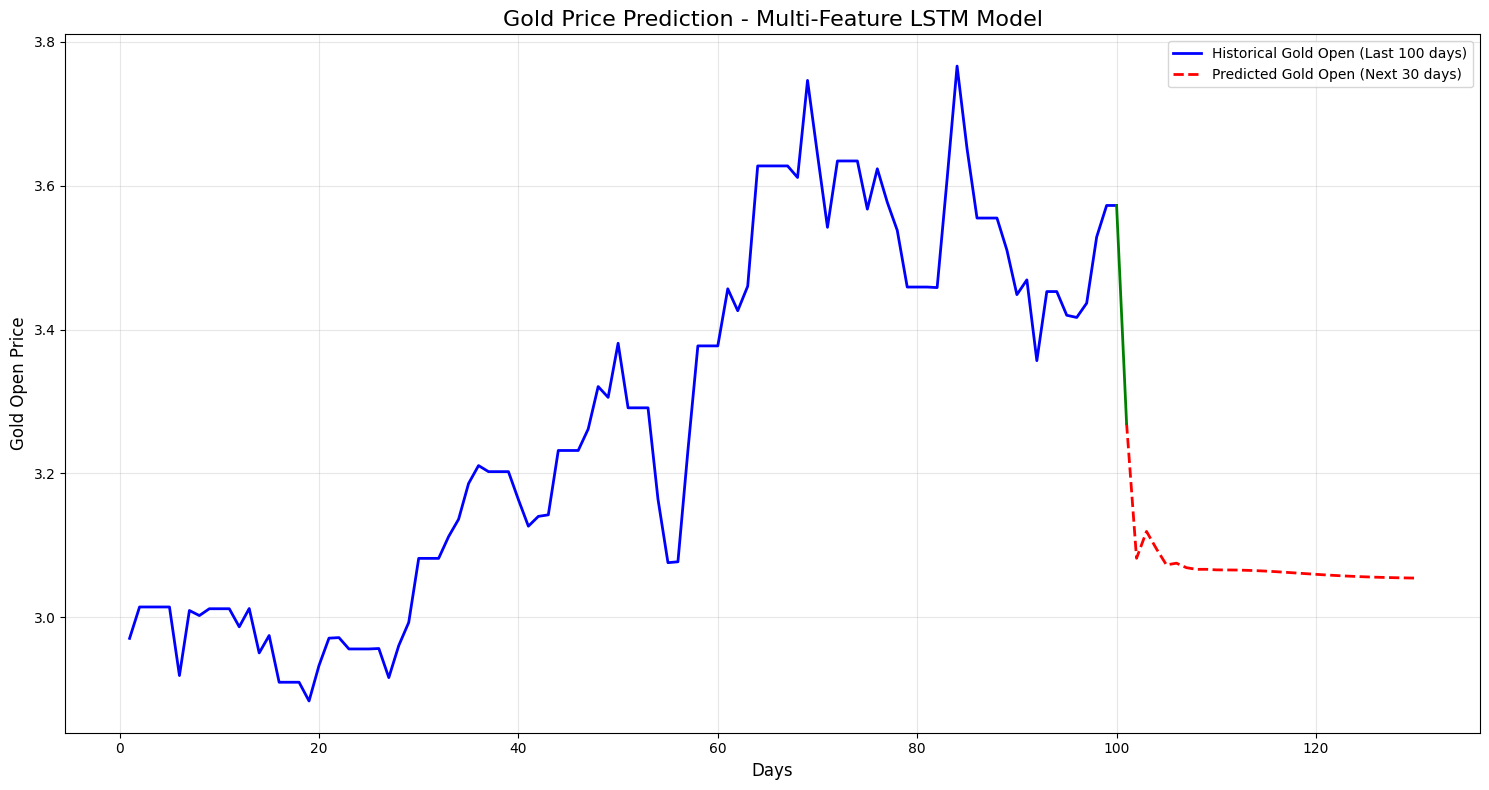

In [45]:
# Vẽ biểu đồ
try:
    plt.figure(figsize=(15, 8))
    
    # Dữ liệu gốc (100 ngày cuối)
    if len(test_target) >= 100:
        last_100_days = scaler_target.inverse_transform(test_target[-100:]).flatten()
    else:
        last_100_days = scaler_target.inverse_transform(test_target).flatten()
        
    days_historical = np.arange(1, len(last_100_days) + 1)
    
    # Dự đoán 30 ngày tiếp theo
    days_future = np.arange(len(last_100_days) + 1, len(last_100_days) + 31)
    
    print(f"Historical days: {len(days_historical)}, Future days: {len(days_future)}")
    print(f"Historical data: {len(last_100_days)}, Future predictions: {len(future_predictions_original)}")
    
    # Vẽ biểu đồ
    plt.plot(days_historical, last_100_days, label='Historical Gold Open (Last 100 days)', color='blue', linewidth=2)
    plt.plot(days_future, future_predictions_original, label='Predicted Gold Open (Next 30 days)', color='red', linewidth=2, linestyle='--')
    
    # Kết nối điểm cuối và điểm đầu prediction
    if len(last_100_days) > 0 and len(future_predictions_original) > 0:
        plt.plot([days_historical[-1], days_future[0]], [last_100_days[-1], future_predictions_original[0]], color='green', linewidth=2)
    
    plt.title('Gold Price Prediction - Multi-Feature LSTM Model', fontsize=16)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Gold Open Price', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Force display
    plt.draw()
    plt.pause(0.1)
    plt.show(block=True)
    
except Exception as e:
    print(f"Error plotting first chart: {e}")
    print("Trying alternative plotting method...")
    
    # Phương pháp vẽ thay thế
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Sử dụng dữ liệu đơn giản hơn
    historical_data = df_target.tail(100).values
    ax.plot(range(100), historical_data, label='Historical', color='blue')
    
    if len(future_predictions_original) > 0:
        ax.plot(range(100, 130), future_predictions_original, label='Predicted', color='red', linestyle='--')
    
    ax.set_title('Gold Price Prediction')
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

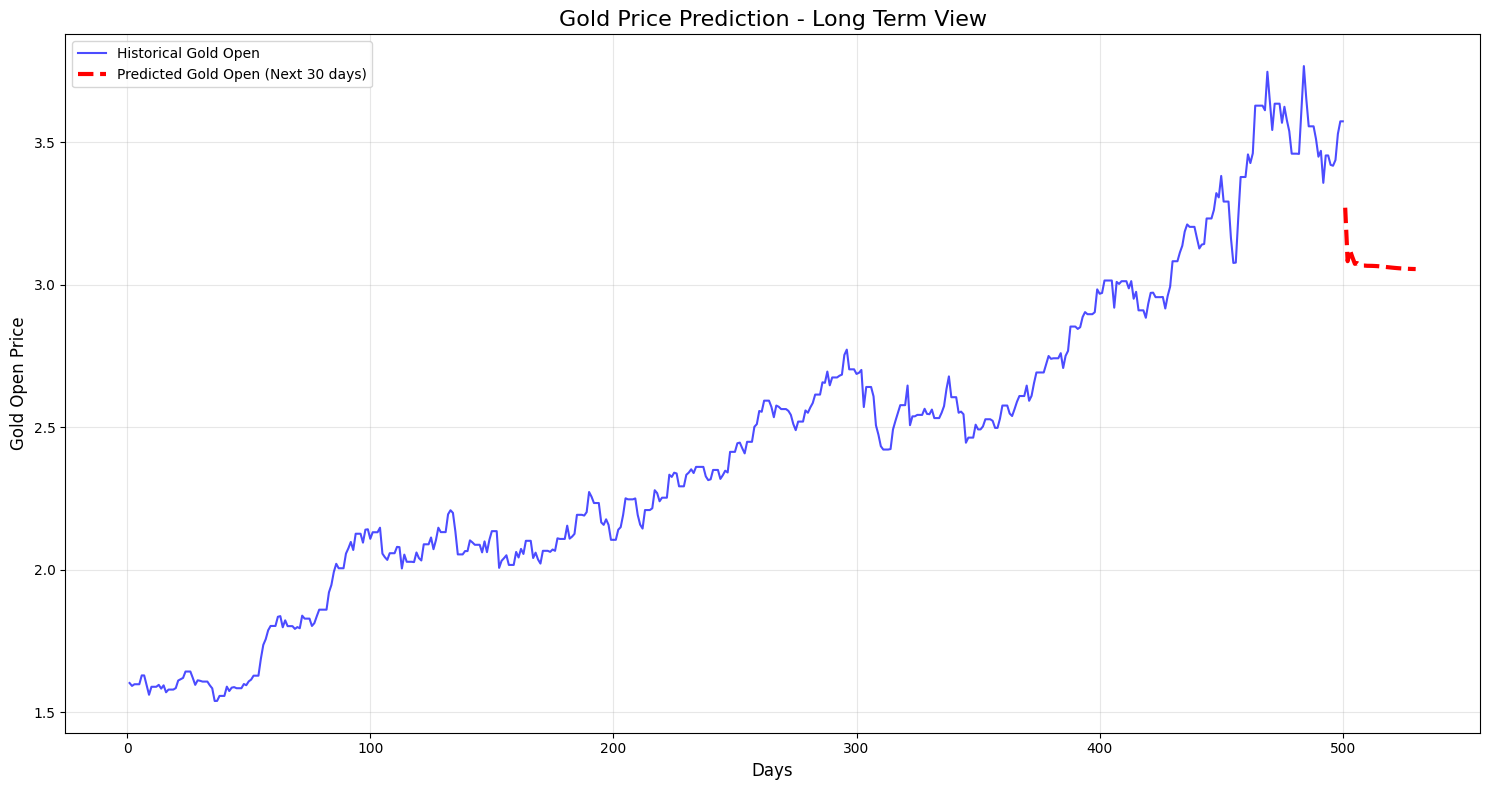

In [46]:
# Vẽ biểu đồ tổng quan
try:
    plt.figure(figsize=(15, 8))
    
    # Lấy dữ liệu an toàn
    if len(scaled_target) >= 500:
        last_500_days = scaler_target.inverse_transform(scaled_target[-500:]).flatten()
        days_long = np.arange(1, 501)
        days_future_long = np.arange(501, 531)
    else:
        last_500_days = scaler_target.inverse_transform(scaled_target).flatten()
        days_long = np.arange(1, len(last_500_days) + 1)
        days_future_long = np.arange(len(last_500_days) + 1, len(last_500_days) + 31)
    
    plt.plot(days_long, last_500_days, label='Historical Gold Open', color='blue', alpha=0.7)
    
    if len(future_predictions_original) > 0:
        plt.plot(days_future_long, future_predictions_original, label='Predicted Gold Open (Next 30 days)', color='red', linewidth=3, linestyle='--')
    
    plt.title('Gold Price Prediction - Long Term View', fontsize=16)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Gold Open Price', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show(block=True)
    
except Exception as e:
    print(f"Error plotting second chart: {e}")
    
    # Vẽ biểu đồ đơn giản thay thế
    plt.figure(figsize=(12, 6))
    
    # Chỉ vẽ dự đoán nếu có data
    if len(future_predictions_original) > 0:
        plt.plot(range(30), future_predictions_original, 'ro-', label='30-Day Predictions', linewidth=2)
        plt.title('Gold Price Predictions - Next 30 Days')
        plt.xlabel('Day')
        plt.ylabel('Predicted Gold Open Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(range(0, 30, 5))
        plt.tight_layout()
        plt.show()
    else:
        print("No prediction data to plot")


In [48]:
# In thống kê dự đoán
print("\n=== PREDICTION STATISTICS ===")
print(f"Average predicted price: ${np.mean(future_predictions_original):.2f}")
print(f"Min predicted price: ${np.min(future_predictions_original):.2f}")
print(f"Max predicted price: ${np.max(future_predictions_original):.2f}")
print(f"Standard deviation: ${np.std(future_predictions_original):.2f}")


=== PREDICTION STATISTICS ===
Average predicted price: $3.07
Min predicted price: $3.05
Max predicted price: $3.27
Standard deviation: $0.04


In [49]:
# In dự đoán từng ngày
print("\n=== DAILY PREDICTIONS ===")
for i, pred in enumerate(future_predictions_original, 1):
    print(f"Day {i}: ${pred:.2f}")


=== DAILY PREDICTIONS ===
Day 1: $3.27
Day 2: $3.08
Day 3: $3.12
Day 4: $3.10
Day 5: $3.07
Day 6: $3.08
Day 7: $3.07
Day 8: $3.07
Day 9: $3.07
Day 10: $3.07
Day 11: $3.07
Day 12: $3.07
Day 13: $3.07
Day 14: $3.06
Day 15: $3.06
Day 16: $3.06
Day 17: $3.06
Day 18: $3.06
Day 19: $3.06
Day 20: $3.06
Day 21: $3.06
Day 22: $3.06
Day 23: $3.06
Day 24: $3.06
Day 25: $3.06
Day 26: $3.06
Day 27: $3.06
Day 28: $3.06
Day 29: $3.05
Day 30: $3.05
